In [3]:
# !pip install lightautoml==0.3.8b1 

^C


ERROR: Could not install packages due to an OSError: [WinError 32] Процесс не может получить доступ к файлу, так как этот файл занят другим процессом: 'C:\\Users\\user\\.conda\\envs\\py310\\Lib\\site-packages\\plotly\\validators\\mesh3d\\colorbar\\tickformatstop\\_value.py'
Consider using the `--user` option or check the permissions.



  Obtaining dependency information for lightautoml==0.3.8b1 from https://files.pythonhosted.org/packages/ff/4d/e4e181da6cfa5326ca564b68f4b3878062f694aa4027099d002ba152139e/lightautoml-0.3.8b1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/215.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/215.7 kB ? eta -:--:--
     ------------ ------------------------ 71.7/215.7 kB 787.7 kB/s eta 0:00:01
     -------------------------------------- 215.7/215.7 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
     ---------------------------------------- 0.2/101.0 MB 4.6 MB/s eta 0:00:22
     ---------------------------------------- 0.4/101.0 MB 5.0 MB/s eta 0:00:21
     ---------------------------------------- 0.7/101.0 MB 5.7 MB/s eta 0:00:18
     ---------------------------------------- 1.0/101.0 MB 5.6 MB/s eta 0:00:18
     ---------------------------------------- 1.2/101.0 MB 5.6 MB/s eta 0:00:18
  

In [1]:
# Standard python libraries
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

C:\Users\user\.conda\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set some constants for reproducibility

RANDOM_STATE = 42
N_THREADS = 6

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## 1. Загрузка данных

In [3]:
TARGET_NAME = 'Survived'

data = pd.read_csv('data/X_train_automl.csv', index_col='PassengerId')
data.sample(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,label,cabin_type,status,is_alone,is_4_members,is_3or2_members,age*class,quad_fare
PassengerId,,,,,,,,,,,,,,
710,1,0.242363,0,1,2,1,none,n,Master,0,0,1,0.242363,232.434418
440,0,0.472826,0,1,1,0,CA,n,Mr,1,0,0,0.472826,110.250000
841,0,0.242363,0,1,1,0,SOTON,n,Mr,1,0,0,0.242363,62.805625
721,1,0.472826,1,0,3,0,none,n,Miss,0,0,1,0.000000,1089.000000
40,1,0.242363,1,0,1,1,none,n,Miss,0,0,1,0.000000,126.375819


Разделим данные на обучение и тест

In [4]:
train_data, test_data = train_test_split(
    data,
    test_size=0.2, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data splitted. Parts sizes: train_data = (712, 14), test_data = (179, 14)


,Survived,Pclass,Sex,Age,Fare,Embarked,label,cabin_type,status,is_alone,is_4_members,is_3or2_members,age*class,quad_fare
PassengerId,,,,,,,,,,,,,,
693,1,0.242363,0,1,3,0,none,n,Mr,1,0,0,0.242363,3191.775418
482,0,0.472826,0,1,0,0,none,n,Mr,1,0,0,0.472826,0.000000
528,0,0.629630,0,2,3,0,rare,C,Mr,1,0,0,1.259259,49186.013553
856,1,0.242363,1,1,1,0,none,n,Mrs,0,0,1,0.242363,87.422500
802,1,0.472826,1,1,2,0,CA,n,Mrs,0,0,1,0.472826,689.062500


## 2. Создание и обучение пресета `TabularAutoML`

In [5]:
# specify task type
#  'binary' - for binary classification.
#  'reg' - for regression.
#  'multiclass' - for multiclass classification.
task = Task(
    'binary',  # required
    loss='logloss',
    metric='auc'
)

In [6]:
# specify feature roles
roles = {
    'target': TARGET_NAME,  # required
    # 'drop': ['SK_ID_CURR']  # remove user's id
}

In [8]:
N_FOLDS = 5
TIMEOUT = 60 * 30

In [9]:
RD = ReportDeco(output_path='tabularAutoML_model_report')

automl = TabularAutoML(
    task=task,  # required
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

automl_rd = RD(automl)

In [10]:
%%time
oof_preds = automl_rd.fit_predict(train_data, roles=roles, verbose=1)

[11:41:18] Stdout logging level is INFO.
[11:41:18] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[11:41:18] Task: binary

[11:41:18] Start automl preset with listed constraints:
[11:41:18] - time: 1800.00 seconds
[11:41:18] - CPU: 6 cores
[11:41:18] - memory: 16 GB

[11:41:18] Train data shape: (712, 14)

[11:41:23] Layer 1 train process start. Time left 1795.51 secs
[11:41:23] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:41:24] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8524952647959481
[11:41:24] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:41:24] Time left 1793.86 secs

[11:41:24] Selector_LightGBM fitting and predicting completed
[11:41:24] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The s

[11:41:25] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8574098642435771
[11:41:25] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[11:41:25] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[11:41:40] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[11:41:40] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[11:41:41] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8601174831243168
[11:41:41] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[11:41:41] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[11:41:42] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8425200463924837
[11:41:42] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[11:41:42] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
[11:42:06] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost comp

C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\report\report_deco.py:146: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\report\report_deco.py:153: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


CPU times: total: 3min 5s
Wall time: 52.1 s


In [24]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.14590 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.38475 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.22921 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.24014 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [16]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_preds.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_preds.data[:, 0])}')
print(f'accuracy - {accuracy_score(test_data[TARGET_NAME].values, (test_preds.data > 0.50).astype(int)[:, 0])}')

OOF score: 0.8849825193788747
HOLDOUT score: 0.8559947299077734
accuracy - 0.8212290502793296


Пресет `TabularAutoML` обучался 6.5 минут, несмотря на то, что `TIMEOUT` установлен равным 30 минутам. Чтобы использовать отведенное время, воспользуемся пресетом `TabularUtilizedAutoML` вместо `TabularAutoML`.

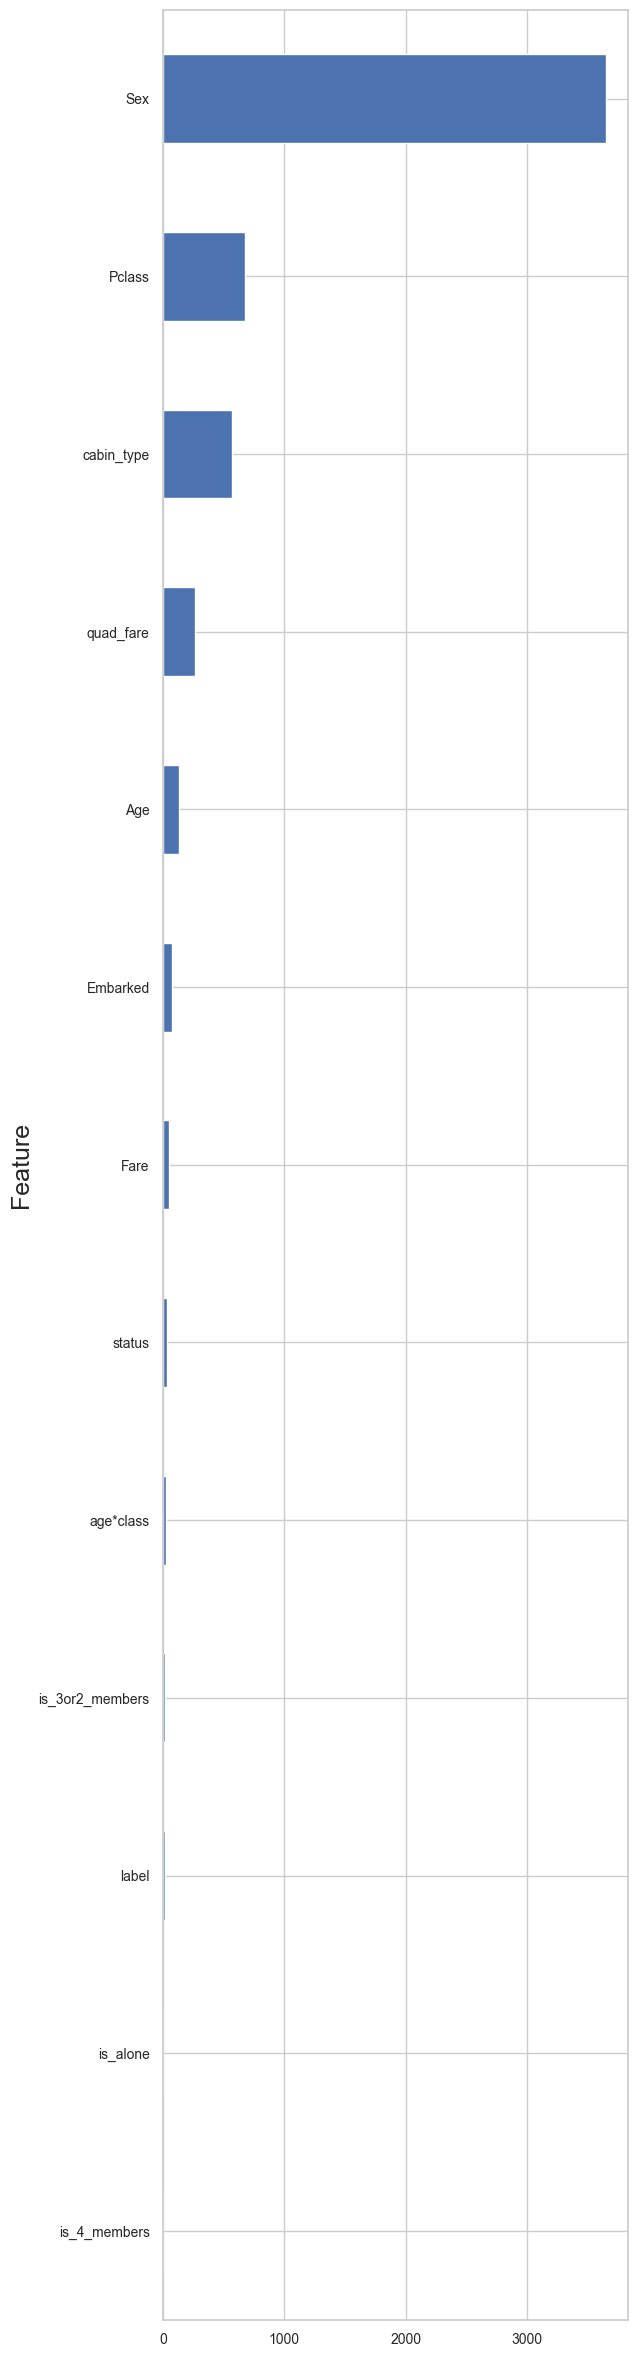

CPU times: total: 234 ms
Wall time: 243 ms


In [18]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.barh(figsize=(6, 30), grid=True, rot=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

In [19]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent=False)

CPU times: total: 4.02 s
Wall time: 722 ms


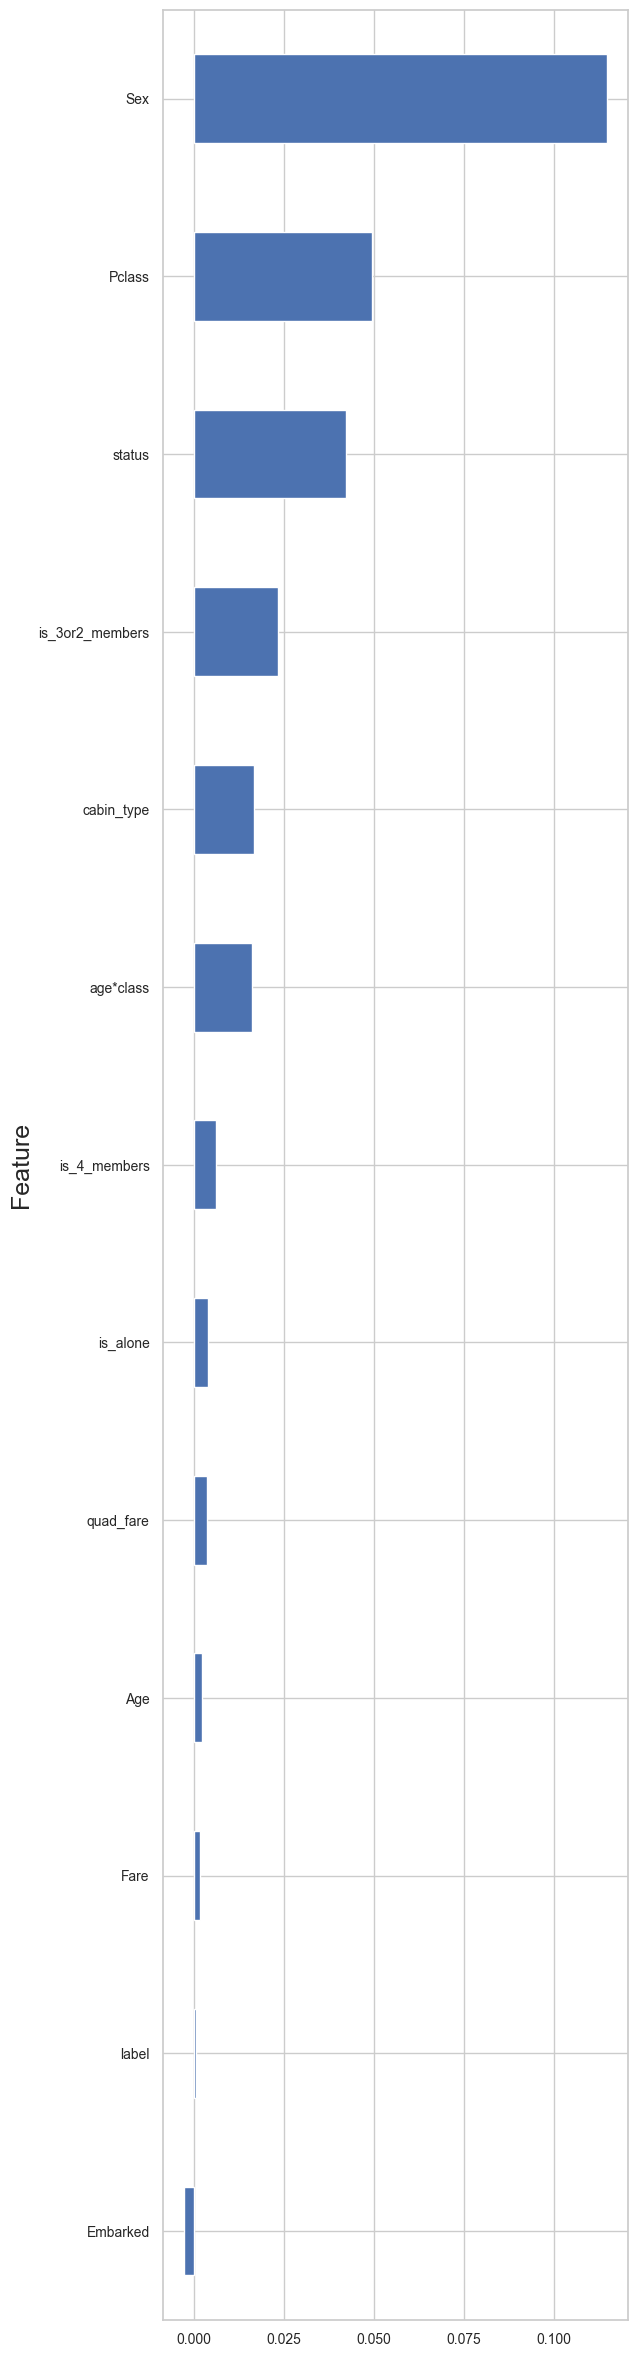

In [20]:
accurate_fi.set_index('Feature')['Importance'].plot.barh(figsize=(6, 30), grid=True, rot=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

## 3. Создание и обучение `TabularUtilizedAutoML`

In [88]:
N_FOLDS = 5
TIMEOUT = 60 * 60 * 5

In [89]:
utilized_automl = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
%%time 
oof_pred = utilized_automl.fit_predict(data, roles=roles, verbose=1)

[15:28:31] Start automl utilizator with listed constraints:
[15:28:31] - time: 18000.00 seconds
[15:28:31] - CPU: 6 cores
[15:28:31] - memory: 16 GB

[15:28:31] If one preset completes earlier, next preset configuration will be started

[15:28:31] ==================================================
[15:28:31] Start 0 automl preset configuration:
[15:28:31] C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[15:28:31] Stdout logging level is INFO.
[15:28:31] Task: binary

[15:28:31] Start automl preset with listed constraints:
[15:28:31] - time: 18000.00 seconds
[15:28:31] - CPU: 6 cores
[15:28:31] - memory: 16 GB

[15:28:31] Train data shape: (891, 14)

[15:28:36] Layer 1 train process start. Time left 17995.66 secs
[15:28:36] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[15:28:38] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8641629118333174
[15:28:38] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:28:38] Time left 17993.71 secs

[15:28:38] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[15:28:39] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.858408163700082
[15:28:39] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:28:39] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[15:29:20] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:29:20] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[15:29:20] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8785724176865966
[15:29:20] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:29:20] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:29:22] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8748974744085471
[15:29:22] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:29:22] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
[15:30:08] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost compl

C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[15:30:15] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.849236783519211
[15:30:15] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:30:15] Time left 17896.26 secs

[15:30:15] Selector_LightGBM fitting and predicting completed
[15:30:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The s

[15:30:16] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8678431811161175
[15:30:16] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:30:16] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[15:30:55] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:30:55] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[15:30:55] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8728123435486105
[15:30:55] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:30:55] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:30:56] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8702585242706037
[15:30:56] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:30:56] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
[15:31:45] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost comp

C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[15:31:49] Selector_LightGBM fitting and predicting completed
[15:31:49] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[15:31:50] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8605465546075266
[15:31:50] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:31:50] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[15:32:52] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:32:52] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[15:32:52] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8839916275205318
[15:32:52] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:32:52] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:32:53] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8539556237284164
[15:32:53] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:32:53] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
[15:33:30] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost comp

C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[15:33:38] Selector_LightGBM fitting and predicting completed
[15:33:38] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\user\.conda\envs\py39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[15:33:39] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8430106839655301
[15:33:39] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:33:39] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[15:33:49] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:33:49] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[15:33:49] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8530528659231564
[15:33:49] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:33:49] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:33:51] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8625944034342077
[15:33:51] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:33:51] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


In [52]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.23607 * 4 averaged models with config = "C:\Users\user\.conda\envs\py310\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.28193 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.47539 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.05252 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.19017 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #1.
		Final prediction for new objects (level 0) = 
			 0.08394 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.23007 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.28994 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.39605 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #2.
		Final prediction for new objects (level 0) = 
			 0.15320 * (5 averaged

In [55]:
%%time

y_pred = utilized_automl.predict(test_data)
print(f'Shape = {y_pred.shape}')

Shape = (179, 1)
CPU times: total: 7.77 s
Wall time: 1.6 s


In [50]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_preds.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, y_pred.data[:, 0])}')
print(f'accuracy - {accuracy_score(test_data[TARGET_NAME].values, (y_pred.data > 0.50).astype(int)[:, 0])}')

OOF score: 0.8849825193788747
HOLDOUT score: 0.8592885375494071
accuracy - 0.8491620111731844


Метрика ROC-AUC немного подросла

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'label', 'cabin_type',
       'status', 'is_alone', 'is_4_members', 'is_3or2_members', 'age*class',
       'quad_fare'],
      dtype='object')

In [86]:
X_test = pd.read_csv('data/X_test_automl.csv')

In [87]:
answer = pd.read_csv('data/gender_submission.csv')
answer.Survived = (utilized_automl.predict(X_test).data > 0.5).astype(int)[:, 0]

ValueError: could not convert string to float: 'Q'

In [121]:
answer.to_csv('data/answer.csv', index=False)

In [122]:
answer.groupby('Survived').count()

,PassengerId
Survived,
0,277
1,141


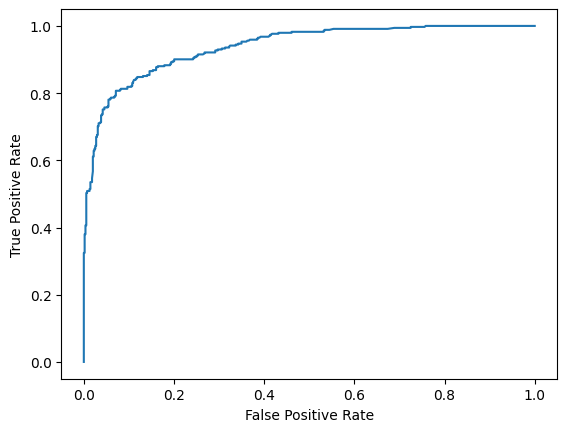

In [96]:
fpr, tpr, _ = roc_curve(data[TARGET_NAME].values, y_pred.data[:, 0])

#create ROC curve
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 